In [1]:
import os
import lib

import numpy as np
import pandas as pd 

from PIL import Image
from matplotlib import pyplot as plt

from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

In [2]:
SEED = 42
VL_SIZE = 0.2

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

learn_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])


learn_data = datasets.ImageFolder('./data/train', transform=learn_transform)
splits = [ int((1-VL_SIZE)*len(learn_data)), int((VL_SIZE)*len(learn_data)) ]

tr_data, vl_data = random_split(learn_data, splits, generator=torch.Generator().manual_seed(SEED))

tr_loader = DataLoader(tr_data, batch_size=64, shuffle=True)
vl_loader = DataLoader(vl_data, batch_size=64, shuffle=True)

In [4]:
model = models.densenet161(pretrained=True)
model.classifier

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/xdg_cache/torch/hub/checkpoints/densenet161-8d451a50.pth


Linear(in_features=2208, out_features=1000, bias=True)

In [5]:
model = lib.freeze_parameters(model)

In [6]:
classifier = nn.Sequential(
  nn.Linear(in_features=2208, out_features=2208),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=2208, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=1024, out_features=10),
  nn.LogSoftmax(dim=1)  
)
    
model.classifier = classifier
model.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=2208, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=2208, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=1024, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

In [7]:
#!g1.1
epoch = 5+5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model, train_loss, test_loss = lib.train(model, tr_loader, vl_loader, epoch, optimizer, criterion)

Epoch: 1/10
		Going for validation
	Train loss:0.369909.. 	Valid Loss:0.275122.. 	Accuracy: 88.8835
	Validation loss decreased (inf --> 0.275122).  Saving model ...
	Epoch:1 completed in 3m 11s
Epoch: 2/10
		Going for validation
	Train loss:0.294544.. 	Valid Loss:0.266825.. 	Accuracy: 89.9775
	Validation loss decreased (0.275122 --> 0.266825).  Saving model ...
	Epoch:2 completed in 2m 52s
Epoch: 3/10
		Going for validation
	Train loss:0.271831.. 	Valid Loss:0.228912.. 	Accuracy: 90.8623
	Validation loss decreased (0.266825 --> 0.228912).  Saving model ...
	Epoch:3 completed in 2m 52s
Epoch: 4/10
		Going for validation
	Train loss:0.285372.. 	Valid Loss:0.233383.. 	Accuracy: 90.9266
	Epoch:4 completed in 2m 51s
Epoch: 5/10
		Going for validation
	Train loss:0.255457.. 	Valid Loss:0.252152.. 	Accuracy: 89.3501
	Epoch:5 completed in 2m 50s
Epoch: 6/10
		Going for validation
	Train loss:0.270462.. 	Valid Loss:0.246234.. 	Accuracy: 90.1544
	Epoch:6 completed in 2m 51s
Epoch: 7/10
		Going f

In [8]:
#!g1.1
model = lib.load_latest_model(model)

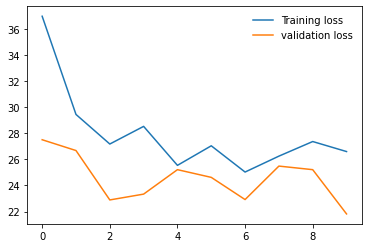

In [9]:
lib.check_overfitted(train_loss, test_loss)

In [10]:
def test(file):
    ids = {'airplane': 0, 'not_airplane': 1}
    with Image.open(file) as f:
        
        img = test_transform(f).unsqueeze(0)
        with torch.no_grad():
            out = model(img.to(device)).cpu().numpy()
            for key, value in ids.items():
                if value == np.argmax(out):
                    #name = classes[int(key)]
                    return value

(20, 20, 4)


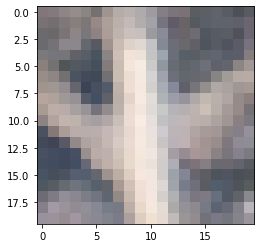

In [11]:
name = '73391958-6b88-40a5-9191-5386b7925b40'
data_dir = './data/test/{}.png'
path = data_dir.format(name)

with Image.open(path) as f:
    print(np.array(f).shape)
    plt.imshow(np.array(f))
    plt.show()

In [12]:
sumb = pd.read_csv('./data/sample_submission.csv')

In [13]:
def predict(s):
    name = s['filename']
    data_dir = './data/test/{}.png'
    path = data_dir.format(name)
    try:
        pred = test(path)
    except RuntimeError:
        print(name)
        pred = 0

    return pred

In [14]:
#!g1.1
preds = sumb[:].apply(predict, axis=1)

73391958-6b88-40a5-9191-5386b7925b40
b4f16723-149f-4179-a258-97b52442de74
93a5da1c-3aea-44aa-9240-96cb8ed18994
103c3b34-63b6-4a2f-a2f8-a6eb85c5be11
71da2b41-4bbf-420b-b5ad-8f5352af0c50
773d6063-5dd0-44f6-b5c1-4409b1e4b6c8
3f895e00-8843-4eed-96ac-a22e8cad699e
43af096e-2776-43f4-bc44-457fc3e33bba
1e3baecb-49ef-456c-9c4c-cdf164b1faca
176a953d-959f-416e-b6da-c47b3ff1e0f5
9e0a7a8e-5412-4792-aeb1-cea4e12ea666
81d83894-0e6f-431a-9971-583f99d94ab9
b09197a8-64ad-436b-9dba-fe2d0d3c7077
e33ca568-3517-4c8f-b96d-3eaaf025295d
1bfd9c52-d8f9-496f-a0db-765eb8cd706e
5e286847-3698-4048-b245-70aa4109afa6
0c24093c-0d2c-4efd-9c29-c0a138946d70
7ab51a9c-0fb9-40f5-bbe6-76370031faf4
9674f377-915c-4059-8a89-2771a51b845d
475adc32-815a-4f06-ae6a-61a992c42fbd
4477ec27-4808-4a77-991e-5048a124095b
dfd9000d-4100-448e-8c28-242d0ae24dcd
01cf8479-f165-497d-9669-e7ad9fad33d5
40ef19b7-f908-4a73-a84b-a6a9e5417b30
fac2c36e-6395-44cc-ab73-d01f813eb605
397b4845-0de8-4a83-9074-a945b85e39b9
92c3951e-ab05-492f-90e8-ece27ffe3efa
c

In [15]:
sumb['sign'] = -1 * (preds.values - 1)

In [16]:
sumb.to_csv('./data/submission.csv', index=False)